In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
# Load images & labels
images = np.load("images.npy")
labels = pd.read_csv("labels.csv")

print("Image array shape:", images.shape)
print("Sample labels:\n", labels.head())

Image array shape: (4750, 128, 128, 3)
Sample labels:
                        Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill


### Class Distribution 

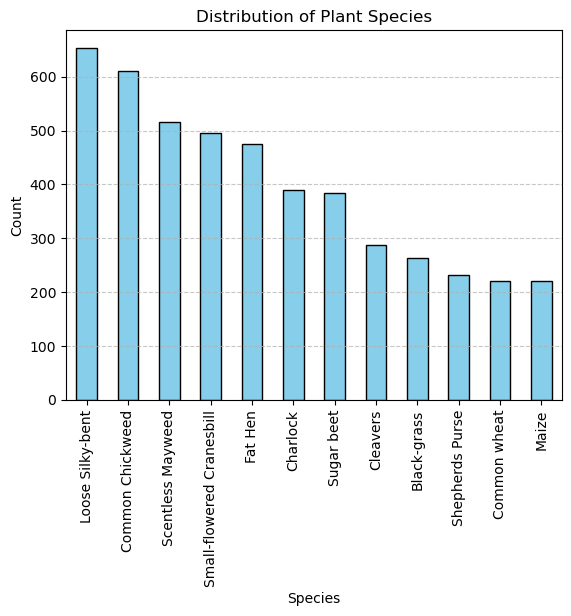

In [17]:
relative_freq = labels['Label'].value_counts()
relative_freq.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Plant Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

View Sample Images of each category

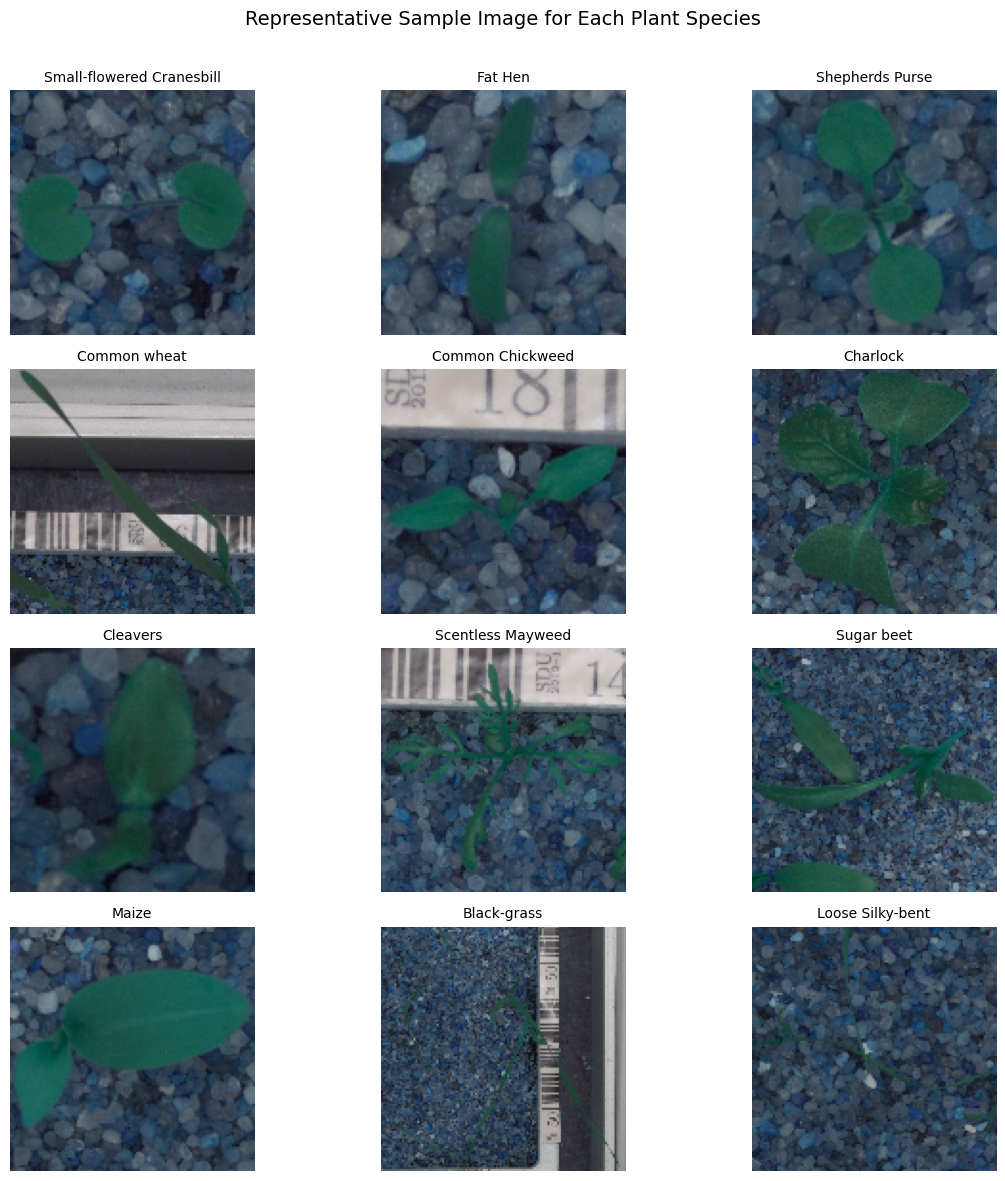

In [18]:
# Create a dictionary mapping each label to one sample index
unique_labels = labels['Label'].unique()
plt.figure(figsize=(12, 12))

for i, label in enumerate(unique_labels):
    idx = labels[labels['Label'] == label].index[0]
    plt.subplot(4, 3, i + 1)
    plt.imshow(images[idx])
    plt.title(label, fontsize=10)
    plt.axis('off')

plt.suptitle("Representative Sample Image for Each Plant Species", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

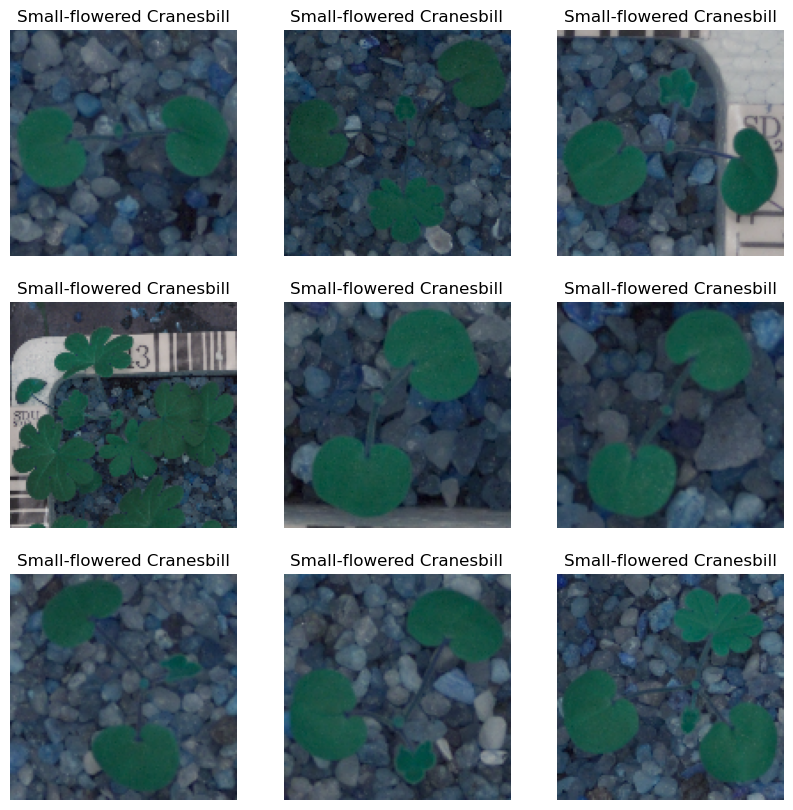

In [19]:

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels['Label'][i])
    plt.axis("off")
plt.show()

### Data Augmentation

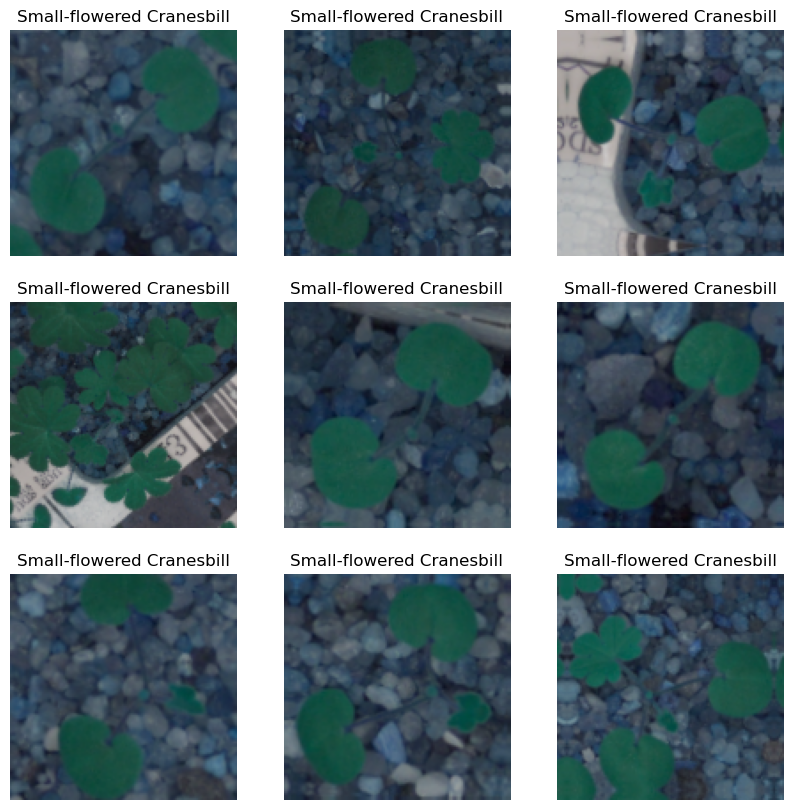

In [20]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Visualize augmentation
plt.figure(figsize=(10,10))
for i in range(9):
    aug_img = data_augmentation(tf.expand_dims(images[i],0))
    plt.subplot(3,3,i+1)
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.title(labels['Label'][i])
    plt.axis("off")
plt.show()

### Normalization

In [21]:
images = images.astype("float32")

### Label Encoding

In [22]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(labels['Label'])

### Train/Validation/Test Split

In [23]:
X_train, X_temp, y_train_int, y_temp_int = train_test_split(
    images, y_int, test_size=0.30, stratify=y_int, random_state=42
)

X_val, X_test, y_val_int, y_test_int = train_test_split(
    X_temp, y_temp_int, test_size=0.50, stratify=y_temp_int, random_state=42
)

# Convert to one-hot AFTER split
y_train = to_categorical(y_train_int)
y_val   = to_categorical(y_val_int)
y_test  = to_categorical(y_test_int)

print(len(X_train), len(X_val), len(X_test))

3325 712 713


### Save Preprocessed Data

In [24]:
# Save Datasets: Train / Validation / Test
np.save("train_images.npy", X_train)
np.save("val_images.npy",X_val)
np.save("test_images.npy",X_test)
np.save("train_labels.npy",y_train)
np.save("val_labels.npy",y_val)
np.save("test_labels.npy",y_test)

### Build Model - Transfer Learning (MobileNetV2)

In [25]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False   # Freeze pretrained weights

In [26]:
inputs = layers.Input(shape=(128,128,3))

x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)  # Adjust input scale
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(12, activation="softmax")(x)

model = models.Model(inputs, outputs)

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.003),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 128, 128, 3)       0         
 ial)                                                            
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 128, 128, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 128, 128, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                   

### BackPropogation, Callbacks, and Training

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    shuffle=True
)

Epoch 1/80
104/104 [==============================] - 17s 133ms/step - loss: 1.5298 - accuracy: 0.5044 - val_loss: 1.0817 - val_accuracy: 0.6728 - lr: 0.0030
Epoch 2/80
104/104 [==============================] - 13s 127ms/step - loss: 0.9938 - accuracy: 0.6680 - val_loss: 0.8200 - val_accuracy: 0.7163 - lr: 0.0030
Epoch 3/80
104/104 [==============================] - 15s 146ms/step - loss: 0.8787 - accuracy: 0.7032 - val_loss: 0.8188 - val_accuracy: 0.7079 - lr: 0.0030
Epoch 4/80
104/104 [==============================] - 13s 121ms/step - loss: 0.7933 - accuracy: 0.7311 - val_loss: 0.8472 - val_accuracy: 0.7416 - lr: 0.0030
Epoch 5/80
104/104 [==============================] - 13s 122ms/step - loss: 0.7897 - accuracy: 0.7344 - val_loss: 0.8711 - val_accuracy: 0.7472 - lr: 0.0030
Epoch 6/80
104/104 [==============================] - 13s 123ms/step - loss: 0.7624 - accuracy: 0.7471 - val_loss: 0.8044 - val_accuracy: 0.7528 - lr: 0.0030
Epoch 7/80
104/104 [==============================] 

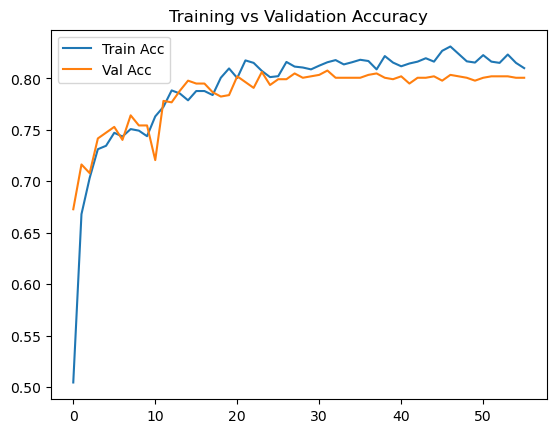

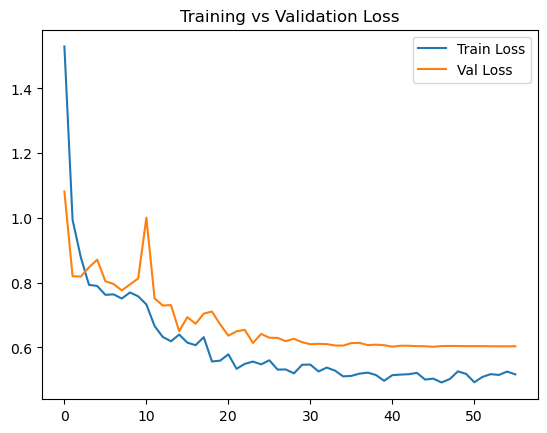

In [29]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

23/23 [==============================] - 3s 95ms/step


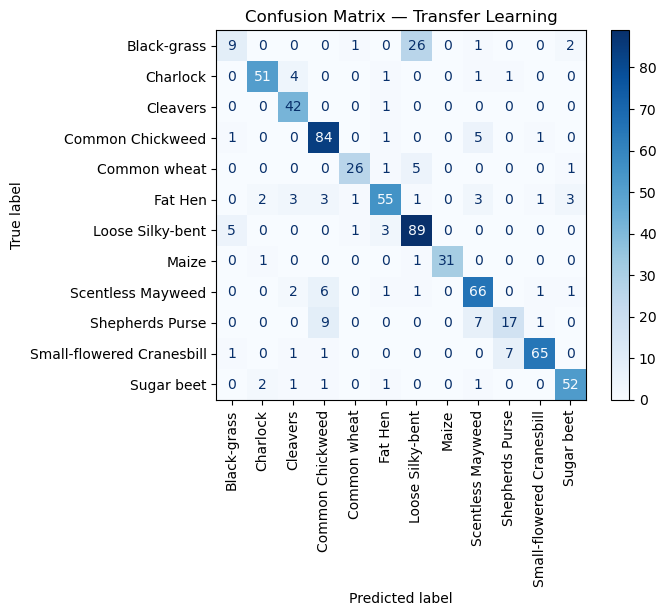

In [30]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = y_test_int

cm = confusion_matrix(y_true_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix — Transfer Learning")
plt.show()

### Continued - Fine-Tune the Model

In [31]:
# Unfreeze top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:120]:  # Freeze first ~60%
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    shuffle=True
)

Epoch 1/15
104/104 [==============================] - 27s 206ms/step - loss: 0.5376 - accuracy: 0.8066 - val_loss: 0.6391 - val_accuracy: 0.7907 - lr: 1.0000e-05
Epoch 2/15
104/104 [==============================] - 21s 204ms/step - loss: 0.5195 - accuracy: 0.8111 - val_loss: 0.6109 - val_accuracy: 0.8020 - lr: 1.0000e-05
Epoch 3/15
104/104 [==============================] - 21s 206ms/step - loss: 0.4852 - accuracy: 0.8232 - val_loss: 0.5941 - val_accuracy: 0.7992 - lr: 1.0000e-05
Epoch 4/15
104/104 [==============================] - 21s 203ms/step - loss: 0.4615 - accuracy: 0.8316 - val_loss: 0.6008 - val_accuracy: 0.8090 - lr: 1.0000e-05
Epoch 5/15
104/104 [==============================] - 21s 198ms/step - loss: 0.4381 - accuracy: 0.8394 - val_loss: 0.5680 - val_accuracy: 0.8034 - lr: 1.0000e-05
Epoch 6/15
104/104 [==============================] - 21s 197ms/step - loss: 0.4347 - accuracy: 0.8460 - val_loss: 0.5564 - val_accuracy: 0.8188 - lr: 1.0000e-05
Epoch 7/15
104/104 [========

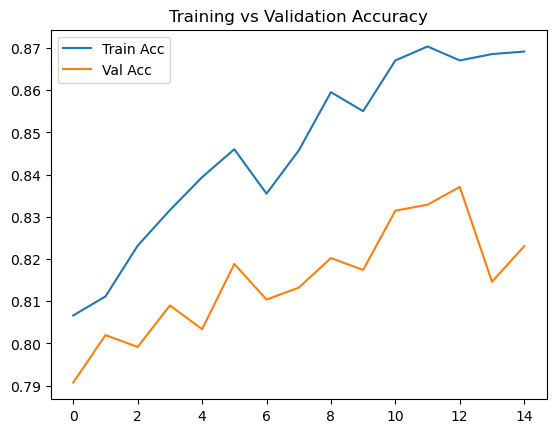

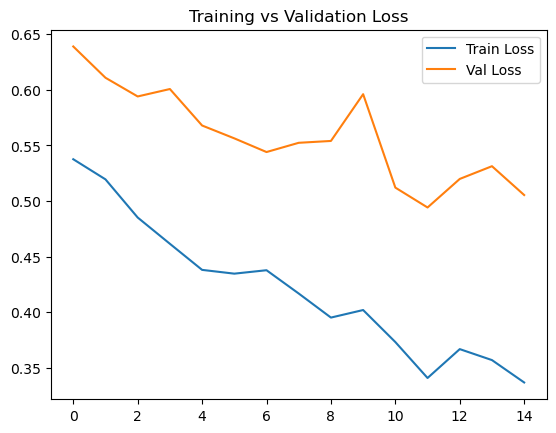

In [32]:
plt.plot(history_fine.history['accuracy'], label='Train Acc')
plt.plot(history_fine.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

### Confusion Matrix and Evaluation

23/23 [==============================] - 3s 89ms/step


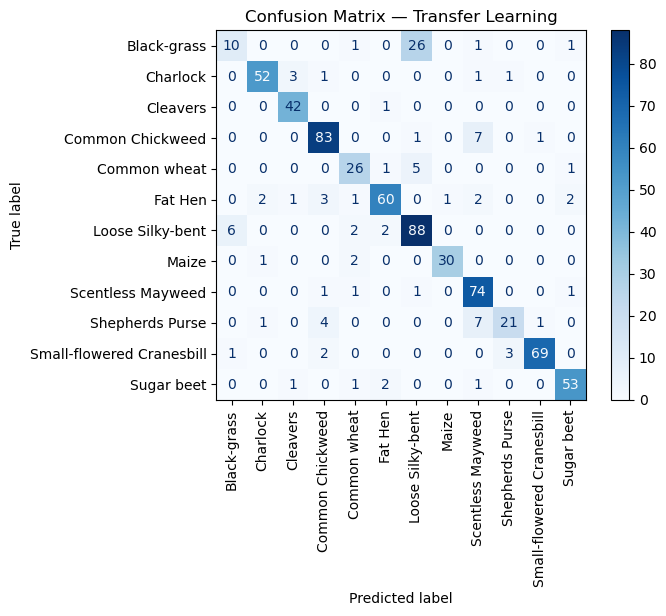

In [33]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = y_test_int

cm = confusion_matrix(y_true_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix — Transfer Learning")
plt.show()

### Plot Loss comparison and the fine-tuned model comparison

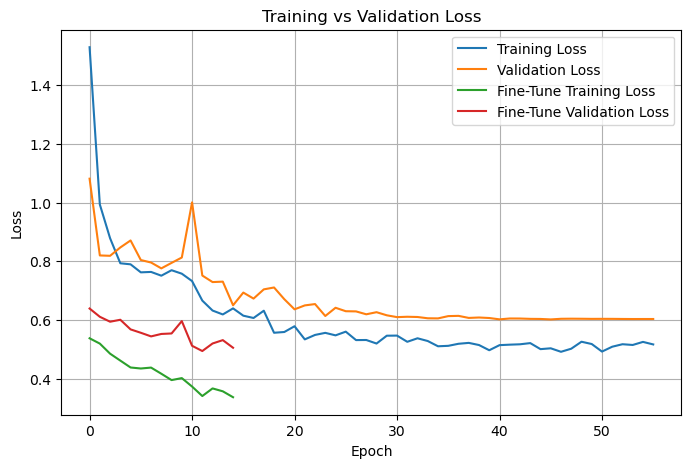

In [34]:
# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# If fine-tuning history exists, append it
try:
    plt.plot(history_fine.history['loss'], label='Fine-Tune Training Loss')
    plt.plot(history_fine.history['val_loss'], label='Fine-Tune Validation Loss')
except:
    pass

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Assessment of Model Fitness and Generalization. Assessing Accuracy

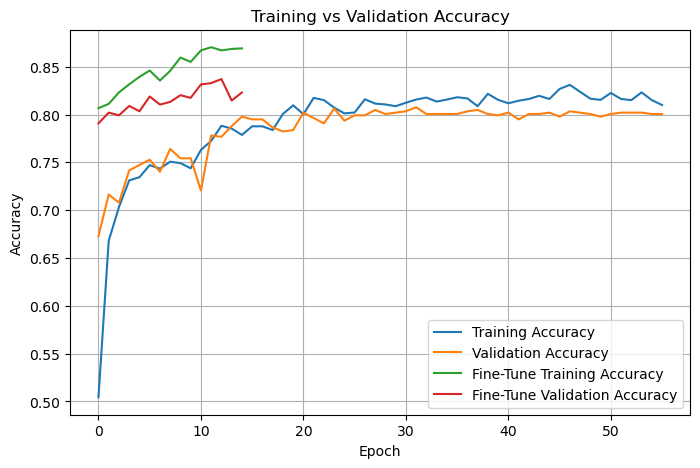

In [40]:
# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# If fine-tuning history exists, append it
try:
    plt.plot(history_fine.history['accuracy'], label='Fine-Tune Training Accuracy')
    plt.plot(history_fine.history['val_accuracy'], label='Fine-Tune Validation Accuracy')
except:
    pass

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Predictive Accuracy on the Test Set

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8527
Test Loss: 0.4806


### Save the Trained Network

In [37]:
# Save the trained model and label encoder
model.save("plant_seedling_model.h5")
np.save("label_classes.npy",label_encoder.classes_)

c:\Users\tyler\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# Reload the model and labels
reloaded_model = tf.keras.models.load_model("plant_seedling_model.h5")
label_classes = np.load("label_classes.npy",allow_pickle=True)